In [12]:
from pandas import read_csv
import pandas as pd

from nltk.sentiment.util import *
from joblib import dump, load
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [13]:
dataset = read_csv("reviews_train.csv")

del dataset["reviewTime"]
del dataset["reviewerName"]
del dataset["reviewerID"]
del dataset["asin"]
dataset['reviewText'] = dataset['reviewText'].apply(lambda x: str(x))
dataset['summary'] = dataset['summary'].apply(lambda x: str(x))
dataset['helpful'] = dataset['helpful'].apply(lambda x: eval(x))

new = pd.DataFrame(dataset["helpful"].to_list(), columns=['helpful', 'nothelpful'])
new["helpful_diff"] = new["helpful"] - new["nothelpful"] 

dataset['helpful'] = new['helpful']
dataset['nothelpful'] = new['nothelpful']
dataset['helpful_diff'] = new['helpful_diff']

dataset

,helpful,reviewText,summary,unixReviewTime,score,nothelpful,helpful_diff
0,0,I have decided not to play this game. I can't...,Friends,1396396800,1.0,0,0
1,3,The Amazon Appstore free app of the day for Ju...,"Amazon Makes This ""Longest Spring Ever"" for Fi...",1402272000,2.0,4,-1
2,0,this game was so mush fun I wish I could play ...,best,1368921600,5.0,4,-4
3,0,"Its pretty fun and very good looking, but you...",Fun Game,1350172800,5.0,2,-2
4,0,good graphics; immersive storyline; hard to st...,great game!,1396915200,5.0,0,0
...,...,...,...,...,...,...,...
555786,0,A great game to play when you are bored. it is...,addictive,1333756800,5.0,0,0
555787,1,"Here's a question, why do people say don't BUY...",Why It's ok...,1391990400,4.0,1,0
555788,0,The graphics are of poor quality and it's a bi...,Poor graphics,1316476800,2.0,0,0
555789,9,This game I know can be fun but how can you pl...,always freezing up,1393718400,1.0,9,0


In [14]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv1 = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = token.tokenize)
text_counts = cv1.fit_transform(dataset['reviewText'])

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, dataset['score'], test_size=0.01, random_state=1)

clf1 = MultinomialNB().fit(X_train, y_train)
predicted = clf1.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

with open('reviewText.pkl', 'wb') as fout:
    pickle.dump((cv1, clf1), fout)

MultinomialNB Accuracy: 0.5825836631881972


In [15]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv2 = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = token.tokenize)
text_counts = cv2.fit_transform(dataset['summary'])


X_train, X_test, y_train, y_test = train_test_split(
    text_counts, dataset['score'], test_size=0.01, random_state=1)

clf2 = MultinomialNB().fit(X_train, y_train)
predicted = clf2.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

with open('summary.pkl', 'wb') as fout:
    pickle.dump((cv2, clf2), fout)

MultinomialNB Accuracy: 0.5897804965815041


In [16]:
vector = cv1.transform(dataset['reviewText'])
predicted = clf1.predict(vector)
dataset['reviewText'] = predicted

In [17]:
vector = cv2.transform(dataset['summary'])
predicted = clf2.predict(vector)
dataset['summary'] = predicted

In [18]:
dataset

,helpful,reviewText,summary,unixReviewTime,score,nothelpful,helpful_diff
0,0,5.0,5.0,1396396800,1.0,0,0
1,3,1.0,5.0,1402272000,2.0,4,-1
2,0,5.0,5.0,1368921600,5.0,4,-4
3,0,4.0,5.0,1350172800,5.0,2,-2
4,0,5.0,5.0,1396915200,5.0,0,0
...,...,...,...,...,...,...,...
555786,0,5.0,5.0,1333756800,5.0,0,0
555787,1,3.0,3.0,1391990400,4.0,1,0
555788,0,3.0,2.0,1316476800,2.0,0,0
555789,9,3.0,1.0,1393718400,1.0,9,0


In [19]:
with open('reviewText.pkl', 'rb') as f:
    cv1, clf1 = pickle.load(f)

with open('summary.pkl', 'rb') as f:
    cv2, clf2 = pickle.load(f)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset[['helpful', 'reviewText', 'summary', 'unixReviewTime', 'nothelpful', 'helpful_diff']], dataset['score'], test_size=0.2, random_state=1)

clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predicted = clf.predict(X_test)
print("DecisionTreeClassifier Accuracy:",metrics.accuracy_score(y_test, predicted))
importances = clf.feature_importances_
print(importances)

pickle.dump(clf, open( "clf.pkl", "wb" ) )

DecisionTreeClassifier Accuracy: 0.5970456733148013
[0.05347826 0.3859052  0.13550016 0.33711002 0.0551143  0.03289206]


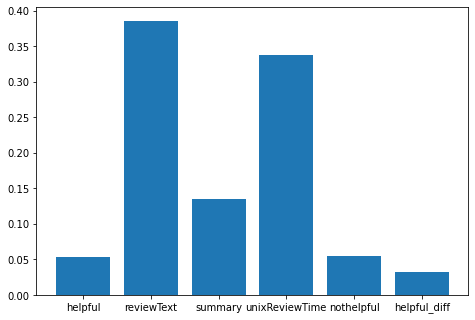

In [32]:
import matplotlib.pyplot as plt

labels = ['helpful', 'reviewText', 'summary', 'unixReviewTime', 'nothelpful', 'helpful_diff']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, importances)
plt.show()